# RNN on Mnist dataset

Teaching the DNN, CNN, RNN based on Minist dataset using PyTorch


Edited by LUXP
Date: 2020-09

In [2]:
########Load required Modules
import torch
from torch import nn, optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

######import functions 
import torch.nn.functional as F
from torch.autograd import Variable

###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'torch'

## 0. Download dataset: MNIST

In [2]:
#### Download train Data set: MNIST, 60000 images with 28*28 
#### Parameters refer to : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download= True,
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

tensor(9)

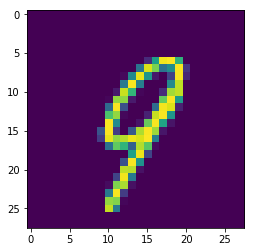

In [5]:
plt.imshow(train_data.data[22,:,:])
train_data.targets[22]

In [6]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
######### download test data
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())

# ## first 2000 images for test
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.targets[:2000]

######### Batch training 50 samples one time, 1 channel, 28*28 (50, 1, 28, 28)
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_data.data.size(), test_x.size(), test_y.size()

(torch.Size([10000, 28, 28]),
 torch.Size([2000, 1, 28, 28]),
 torch.Size([2000]))

tensor(6)

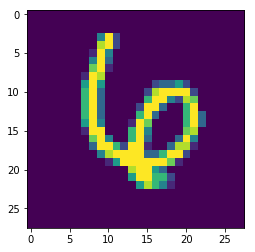

In [10]:
plt.imshow(test_data.data[22,:,:])
test_data.targets[22]

# 1. RNN

Recurrent Neural Network

In [13]:
######### define a RNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=28,
            hidden_size=64,
            num_layers=1,
            batch_first=True)
        
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        
        out = self.out(r_out[:,-1,:])
        return out

In [21]:
####### Declare a net
model = Net().to(device)

#######define LOSS and Optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

####### show the net frame
model

Net(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [22]:
######## Train the model
model.train()
MAX_EPOCH = 3
for epoch in range(MAX_EPOCH):
    for step, (inputs, labels) in enumerate(train_loader):
        #print(step, inputs.size(), labels.size())
        inputs = inputs.view(-1, 28, 28)     #####IMPORTANT!!!!!!!
        #print(step, inputs.size(), labels.size())
        
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        
        outputs = model(inputs)
        #zero the parameter gradients
        optimizer.zero_grad()
        # forward and backward and optimze
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        ##print loss in each 50 steps
        if step % 500 == 0: # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, step+1, loss.data.item()))
print('Finished Training')    

[1,     1] loss: 2.314
[1,   501] loss: 0.199
[2,     1] loss: 0.090
[2,   501] loss: 0.212
[3,     1] loss: 0.092
[3,   501] loss: 0.100
Finished Training


In [23]:
########Evaluate model
model.eval()
loss = 0.0
correct = 0.0

for inputs, labels in test_loader:
    inputs = inputs.view(-1, 28, 28)

    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    outputs = model(inputs)
    ####### calculate the sum of loss
    loss += criterion(outputs, labels).data.item()
    
    ####### calulate teh accuracy
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    correct += sum(c)

print('Correct Recognition: ', correct)            
acc = 100.*correct/len(test_loader.dataset)
print('Testset:\nBatch numbers:', len(test_loader), 'Inputs numbers:', len(test_loader.dataset))
print('Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(loss/len(test_loader), correct, len(test_loader.dataset), acc))

Correct Recognition:  tensor(9771.)
Testset:
Batch numbers: 157 Inputs numbers: 10000
Average loss: 0.0781, Accuracy: 9771.0/10000 (97.7100%)


tensor([[-3.7257, -0.3627, -1.7122,  0.4181,  1.0198, -2.6286, -4.3901,  2.8825,
         -2.0142,  8.0094]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([8.0094]),
indices=tensor([9]))
tensor([9]) tensor(9)


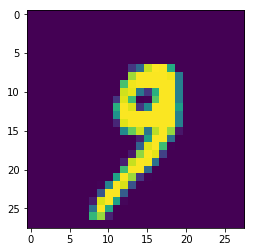

In [24]:
######visualization for single test
img = test_data.data[1000].type(torch.FloatTensor)/255.
plt.imshow(img)
lab = test_data.targets[1000]
## predict
img = img.to(device)
outputs = model(img.view(-1, 28, 28))
print(outputs)
pred_lab = torch.max(outputs.data, 1)
print(pred_lab)
print(pred_lab[1], lab)